### Подключение библиотек и скриптов

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
TRAIN_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/МЕГАФОН/data_train.csv'
TEST_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/МЕГАФОН/data_test.csv'
FEATURES = '/Users/admin/Desktop/GeekBrains/МЕГАФОН/features.csv'

## Разведочный анализ данных (EDA)

In [437]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Unnamed: 0' )
df_train.head(2) 

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0


- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- id - идентификатор абонента
- vas_id - подключаемая услуга

In [438]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Unnamed: 0' )
df_test.head(2)

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000


Переведем столбец 'buy_time' к формату date:

In [439]:
df_train['buy_time'] = df_train['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [440]:
df_test['buy_time'] = df_test['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [441]:
df_train['vas_id'] = df_train['vas_id'].astype('int64')

In [442]:
df_test['vas_id'] = df_test['vas_id'].astype('int64')

In [443]:
df_train['target'] = df_train['target'].astype('int64')

In [444]:
 df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        831653 non-null  int64 
 1   vas_id    831653 non-null  int64 
 2   buy_time  831653 non-null  object
 3   target    831653 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 31.7+ MB


In [445]:
df_train.describe()

,id,vas_id,target
count,8.316530e+05,831653.000000,831653.000000
mean,2.158304e+06,2.686185,0.072369
std,1.257907e+06,1.952034,0.259098
min,2.000000e+00,1.000000,0.000000
25%,1.067319e+06,1.000000,0.000000
50%,2.144574e+06,2.000000,0.000000
75%,3.244254e+06,4.000000,0.000000
max,4.362694e+06,9.000000,1.000000


In [446]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        71231 non-null  int64 
 1   vas_id    71231 non-null  int64 
 2   buy_time  71231 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.2+ MB


In [43]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 831653
Строк в тесте 71231


In [8]:
df_train.head(2)

,id,vas_id,buy_time,target
0,540968,8,2018-09-17,0
1,1454121,4,2018-07-16,0


In [44]:
df_test.head(2)

,id,vas_id,buy_time
0,3130519,2,2019-01-20
1,2000860,4,2019-01-20


In [9]:
# есть 8 видов услуг

df_train.vas_id.nunique()

8

In [462]:
df_train.vas_id.value_counts()

1    310175
2    249505
5     94085
4     85756
6     57878
7     15432
8     13350
9      5472
Name: vas_id, dtype: int64

In [10]:
# число уникальных пользователей:

df_train.id.nunique()

806613

In [12]:
# %conda install dask

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [26]:
%%time

df_features = pd.read_csv(FEATURES, sep='\t')
df_features.head(2)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0


Функция для уменьшения использования памяти компьютера, для комфортной работы с датасетом:

In [28]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [29]:
df_features = reduce_mem_usage(df_features)

Memory usage of dataframe is 8813.53 MB
Memory usage after optimization is: 4406.77 MB
Decreased by 50.0%


In [33]:
df_features = df_features.drop(columns='Unnamed: 0', axis=1)

In [34]:
df_features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910028,46.980888,4.969214,-1.386798,3.791754,-14.011789,-16.08618,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-301.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
1,2014722,1539550800,36.690029,152.400894,448.069214,563.833191,463.841766,568.998230,-16.08618,-53.216099,...,-891.373840,-544.770813,-20.996269,48.369553,80.252274,-13.832889,-0.694429,-1.175933,-0.456140,0.0
2,2015199,1545598800,-67.019974,157.050888,-63.180786,178.103195,-68.598244,156.998215,3.51382,25.183903,...,-977.373840,-613.770813,-12.996268,-37.630447,10829.251953,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,2021765,1534107600,7.010029,150.200882,-6.930786,216.213196,76.621758,351.848206,-16.08618,-65.076096,...,-973.373840,-613.770813,-23.996269,-37.630447,-205.747726,-24.832888,-0.694429,-11.175933,-0.456140,1.0
4,2027465,1533502800,-90.439972,134.220886,-104.380783,153.643204,-109.798248,132.538208,-16.08618,-65.076096,...,1643.626099,2007.229248,206.003738,-21.630449,6667.252441,92.167114,-0.694429,49.824066,47.543861,0.0


In [35]:
df_features['buy_time'] = df_features['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [36]:
df_features.head(2)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-16,18.910028,46.980888,4.969214,-1.386798,3.791754,-14.011789,-16.08618,-65.076096,...,-977.37384,-613.770813,-25.996269,-37.630447,-301.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
1,2014722,2018-10-15,36.690029,152.400894,448.069214,563.833191,463.841766,568.998230,-16.08618,-53.216099,...,-891.37384,-544.770813,-20.996269,48.369553,80.252274,-13.832889,-0.694429,-1.175933,-0.45614,0.0


In [428]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4512528 entries, 0 to 4512527
Columns: 255 entries, id to 252
dtypes: float32(253), int32(1), object(1)
memory usage: 4.3+ GB


Видим, что все, кроме одного, признаки числовые (тип float или int). К категориальному относится столбец 'buy_time'.

In [432]:
df_features.dtypes

id            int32
buy_time     object
0           float32
1           float32
2           float32
             ...   
248         float32
249         float32
250         float32
251         float32
252         float32
Length: 255, dtype: object

In [435]:
df_features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,...,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06,4.512528e+06
mean,2.182050e+06,-1.058114e-03,-3.842604e-04,-1.694036e-04,-5.305484e-05,3.576203e-04,7.018677e-04,-2.324846e-03,4.713951e-03,9.396668e-04,...,3.094775e-02,1.311576e-02,-3.343372e-03,2.418797e-03,-2.099399e-03,5.933698e-04,-1.539911e-04,-5.677469e-04,6.752124e-05,2.559718e-01
std,1.259141e+06,2.260099e+02,4.363452e+02,2.397260e+02,5.033812e+02,2.549493e+02,5.659307e+02,1.548550e+02,3.162827e+02,1.014087e+02,...,3.146590e+03,2.200998e+03,9.482018e+02,2.965778e+02,1.344062e+03,2.926968e+02,1.471185e+01,1.902213e+02,6.980623e+00,1.276776e+00
min,0.000000e+00,-2.482300e+03,-1.594119e+03,-3.058041e+03,-8.200307e+03,-3.063458e+03,-8.221412e+03,-2.401586e+03,-8.023561e+02,-1.184754e+03,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.067477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
25%,1.092104e+06,-9.679997e+01,-2.094491e+02,-1.107408e+02,-2.431568e+02,-1.161582e+02,-2.602818e+02,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.057477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
50%,2.181854e+06,-8.496997e+01,-6.072911e+01,-8.532079e+01,-7.942680e+01,-8.783825e+01,-9.378179e+01,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.593738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-2.397477e+02,-2.383289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
75%,3.273591e+06,1.177003e+01,1.180409e+02,2.737921e+01,1.256532e+02,2.912175e+01,1.189582e+02,-1.608618e+01,-5.914610e+01,-6.783660e+00,...,-4.853738e+02,-4.077708e+02,-2.499627e+01,-3.363045e+01,-7.774773e+01,-1.083289e+01,-6.944285e-01,-9.175933e+00,-4.561399e-01,1.000000e+00
max,4.362738e+06,2.117307e+05,2.126061e+05,2.117168e+05,2.133578e+05,2.120953e+05,2.137205e+05,2.118114e+05,2.125836e+05,1.276018e+05,...,2.876716e+05,2.071552e+05,9.801580e+05,5.429037e+04,3.106112e+05,2.053172e+05,1.892330e+04,1.385528e+05,9.489544e+03,1.743000e+03


В данных явно присутствуют выбросы, очень большие разбросы в значениях признаков.

In [47]:
print('Строк в признаках', df_features.shape[0])

Строк в признаках 4512528


Соединим данные из трейна и данные из теста с датасетом из признаков:

In [463]:
df_train = df_train.merge(df_features, how='left', on=['id', 'buy_time'])

In [464]:
df_train.shape

(831653, 257)

In [466]:
df_test = df_test.merge(df_features, how='left', on=['id', 'buy_time'])

In [467]:
df_test.shape

(71231, 256)

In [57]:
# проверка на наличие дублей в трейне
df_train.duplicated().sum()

0

In [60]:
# проверка на наличие дублей в тесте
df_test.duplicated().sum()

0

### Распределение целевой переменной

0    0.927631
1    0.072369
Name: target, dtype: float64

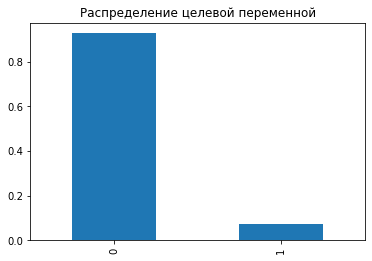

In [61]:
(df_train['target'].value_counts()/df_train['target'].shape[0]).plot(kind='bar', title='Распределение целевой переменной');
df_train['target'].value_counts()/df_train['target'].shape

### Анализ видов услуг

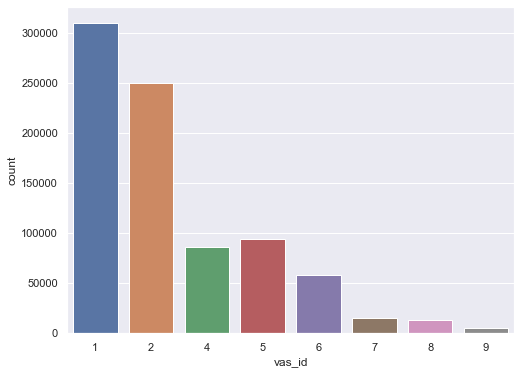

In [476]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
sns.countplot(x='vas_id', data=df_train)
plt.show()

Как видно на графике - самая часто предлагаемая услуга с кодом 1.

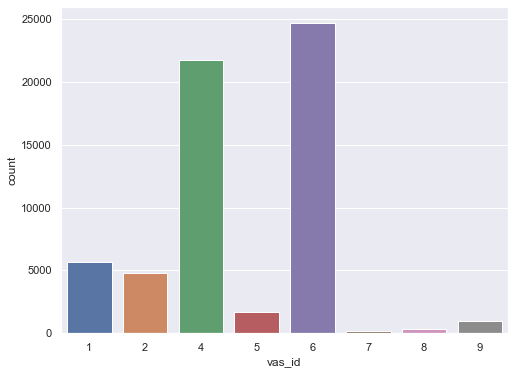

In [477]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
sns.countplot(x='vas_id', data=df_train[df_train['target'] == 1])
plt.show()

Наибольшей популярностью пользуются услуги с кодом 6 и 4 (в случае таргета, равного 1)

### Определение типа признаков и анализ пропущенных значений

In [67]:
# Разделим признаки и целевую переменную
data_prelim = df_train.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [69]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процентов признаков могут принимать null-значения? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процентов признаков могут принимать null-значения? 98%


У 98% признаков есть пропущенные значения, то есть практически во всех.

In [ ]:
import missingno as msno

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [489]:
train_missing= missing_values_table(df_train)
train_missing

Your selected dataframe has 257 columns.
There are 253 columns that have missing values.


,Missing Values,% of Total Values
0,792734,95.3
174,792734,95.3
161,792734,95.3
162,792734,95.3
163,792734,95.3
...,...,...
89,792734,95.3
90,792734,95.3
91,792734,95.3
92,792734,95.3


In [490]:
test_missing= missing_values_table(df_test)
test_missing

Your selected dataframe has 256 columns.
There are 253 columns that have missing values.


,Missing Values,% of Total Values
0,69183,97.1
174,69183,97.1
161,69183,97.1
162,69183,97.1
163,69183,97.1
...,...,...
89,69183,97.1
90,69183,97.1
91,69183,97.1
92,69183,97.1


Как видим, и в трейне и в тесте есть признаки, где очень много пропущенных значений

In [484]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [485]:
f_all = set(X_nunique.index.tolist())
len(f_all)

256

Удалим из признаков 'id' и 'buy_time':

In [530]:
f_all.remove('id')
f_all.remove('buy_time')

In [531]:
# проверим, есть ли константные
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

0

Константных признаков нет

In [532]:
f_binary = set(X.loc[:, f_all].columns[(
                      (X.loc[:, f_all].max() == 1) & \
                      (X.loc[:, f_all].min() == 0) & \
                      (X.loc[:, f_all].isnull().sum() == 0))])
len(f_binary)

0

Бинарных признаков нет.

In [491]:
f_categorical = set(X_nunique.loc[f_all][X_nunique.loc[f_all] <= 10].index.tolist())
len(f_categorical)

46

Категориальных признаков 45, если допустить, что варианты их значений в каждом признаке не больше 10.
Остальные признаки - вещественные, так как все типа float или int. Рассмотрим подробнее, что отнесли к категориальным, и так ли это.

In [493]:
X[f_categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 46 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   32      38919 non-null   float32
 1   206     38919 non-null   float32
 2   203     38919 non-null   float32
 3   202     38919 non-null   float32
 4   218     38919 non-null   float32
 5   205     38919 non-null   float32
 6   204     38919 non-null   float32
 7   31      38919 non-null   float32
 8   24      38919 non-null   float32
 9   95      38919 non-null   float32
 10  139     38919 non-null   float32
 11  216     38919 non-null   float32
 12  vas_id  831653 non-null  int64  
 13  194     38919 non-null   float32
 14  195     38919 non-null   float32
 15  30      38919 non-null   float32
 16  85      38919 non-null   float32
 17  81      38919 non-null   float32
 18  220     38919 non-null   float32
 19  179     38919 non-null   float32
 20  17      38919 non-null   float32
 21  23      38

In [502]:
X[f_categorical].describe()

,32,206,203,202,218,205,204,31,24,95,...,15,155,197,252,16,26,33,196,65,57
count,38919.000000,38919.000000,38919.0,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,3.891900e+04,...,3.891900e+04,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000
mean,0.000028,0.000072,0.0,0.000236,0.000037,0.003350,0.000769,-0.000111,-0.001389,-1.146046e-04,...,-7.249272e-04,0.000160,-0.000053,0.257843,-0.014350,0.004191,0.000021,0.003935,-0.001218,0.000271
std,0.007168,0.094808,0.0,0.039886,0.015207,0.472983,0.192230,0.042073,1.108292,1.469640e-08,...,3.270802e-07,0.043893,0.022661,0.557914,0.187633,0.396974,0.007168,0.436333,0.195460,0.043850
min,-0.000023,-0.008999,0.0,-0.001358,-0.000040,-0.334356,-0.960792,-0.001884,-0.009327,-1.145899e-04,...,-7.252542e-04,-0.000379,-0.000567,0.000000,-0.016435,-0.799862,-0.000030,-0.251959,-0.028454,-0.001656
25%,-0.000023,-0.008999,0.0,-0.001358,-0.000040,-0.334356,0.039208,-0.001884,-0.009327,-1.145899e-04,...,-7.252542e-04,-0.000379,-0.000567,0.000000,-0.016435,0.200138,-0.000030,-0.251959,-0.028454,-0.001656
50%,-0.000023,-0.008999,0.0,-0.001358,-0.000040,-0.334356,0.039208,-0.001884,-0.009327,-1.145899e-04,...,-7.252542e-04,-0.000379,-0.000567,0.000000,-0.016435,0.200138,-0.000030,-0.251959,-0.028454,-0.001656
75%,-0.000023,-0.008999,0.0,-0.001358,-0.000040,0.665644,0.039208,-0.001884,-0.009327,-1.145899e-04,...,-7.252542e-04,-0.000379,-0.000567,1.000000,-0.016435,0.200138,-0.000030,0.748041,-0.028454,-0.001656
max,0.999977,0.991001,0.0,0.998642,2.999960,0.665644,0.039208,0.998116,160.650665,-1.145899e-04,...,-7.252542e-04,4.999620,0.999433,68.000000,17.783566,0.200138,0.999970,0.748041,3.971546,0.998344


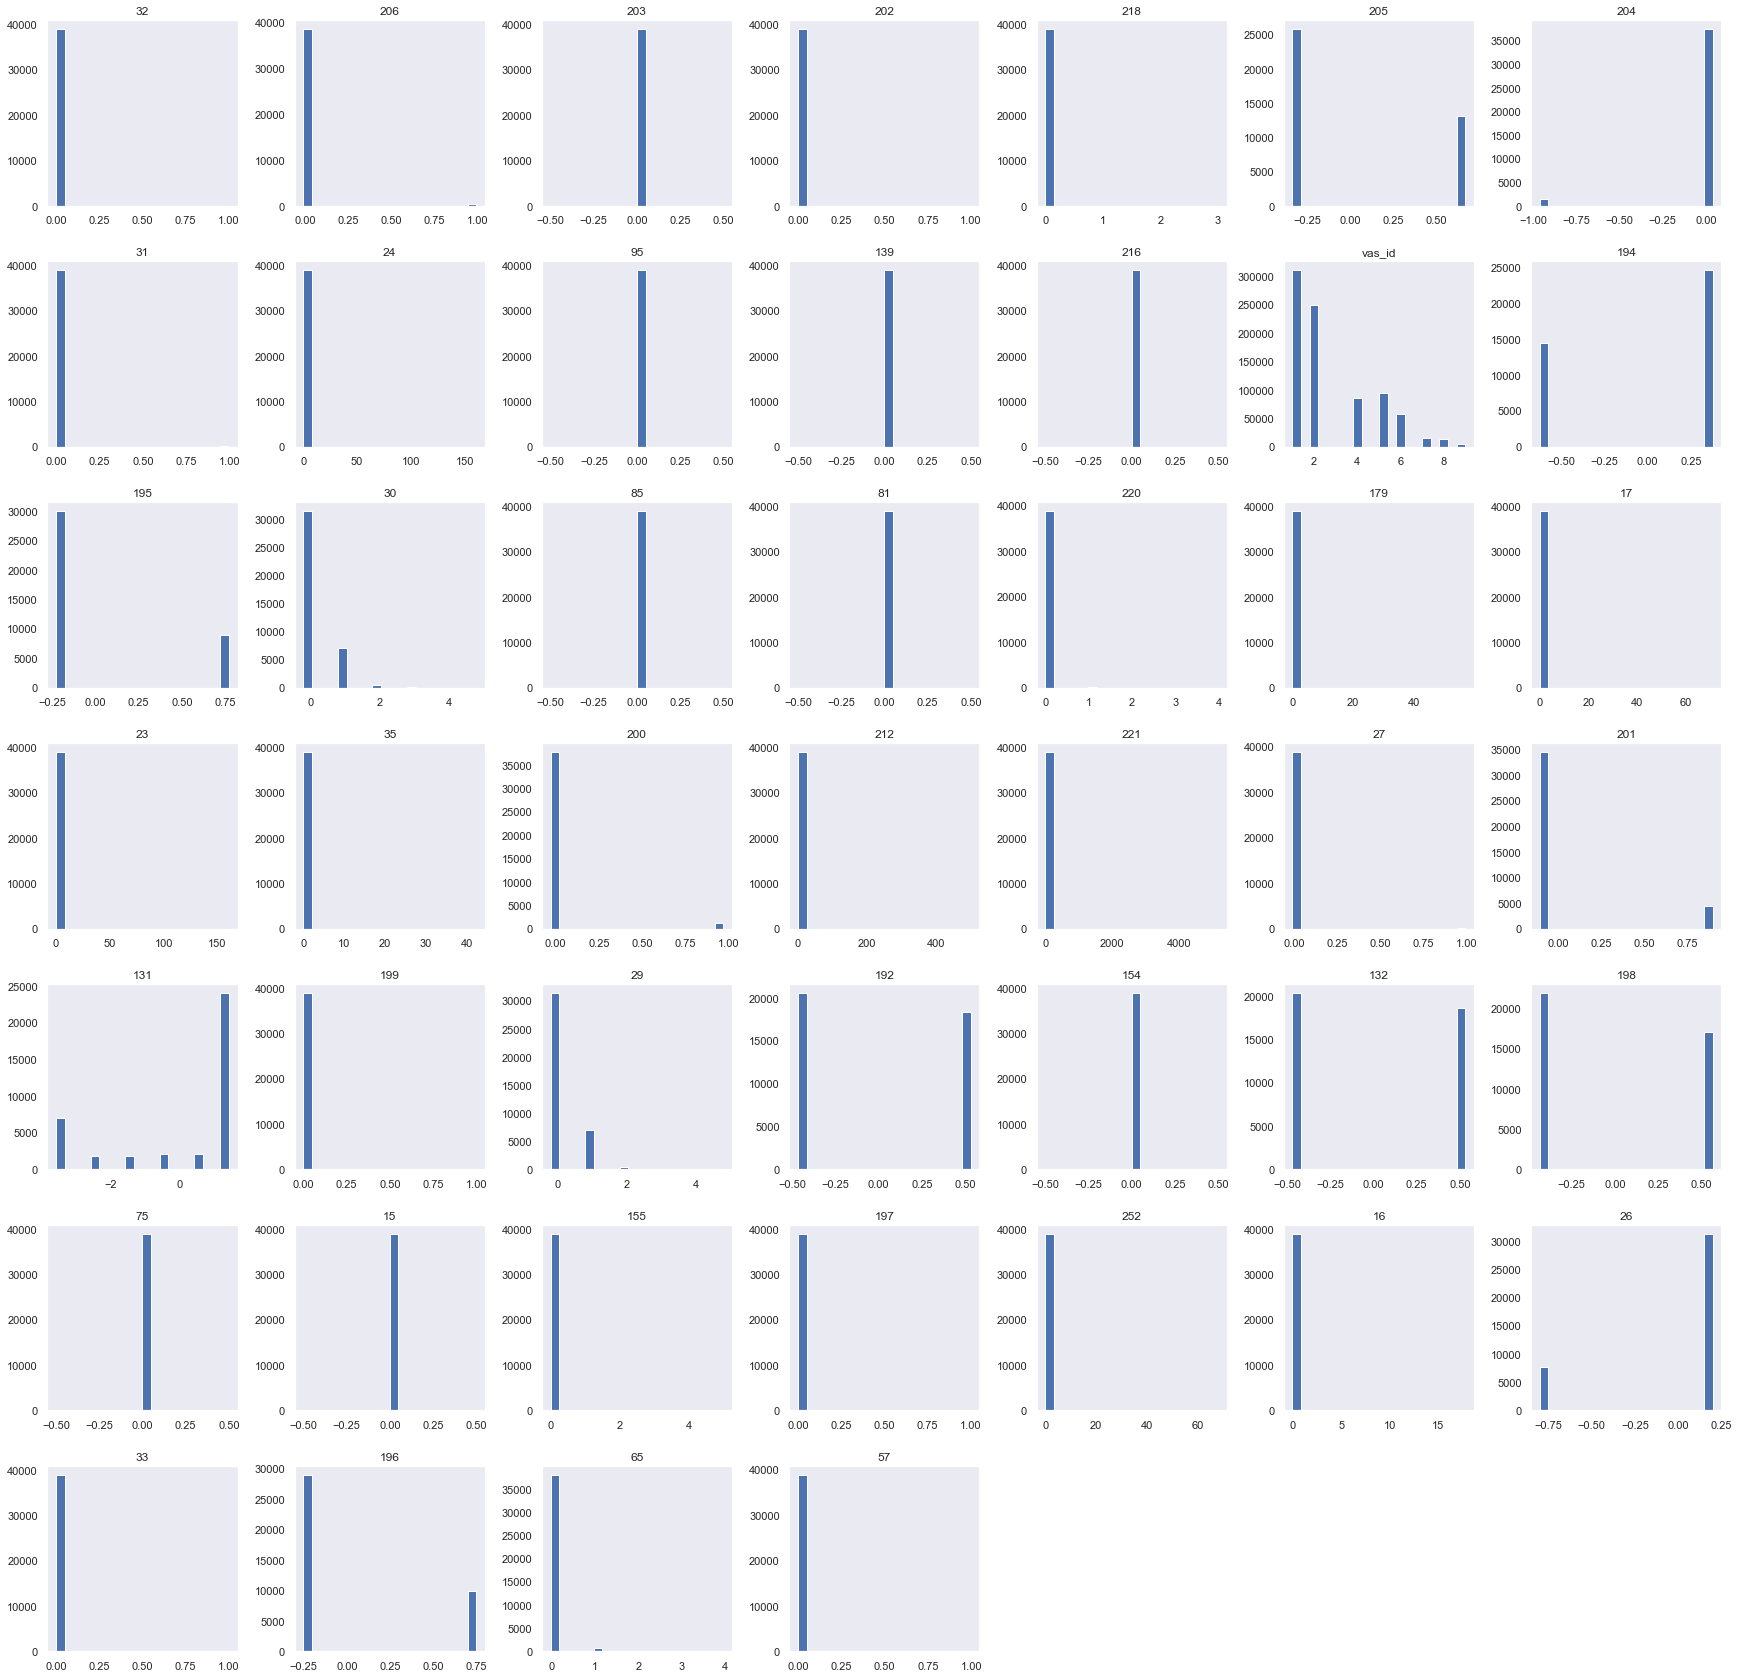

In [557]:
X[f_categorical].hist(figsize=(30, 30), bins=20, grid=False)
plt.show()

Можно предположить, что это какие-то показатели, во многих признаках принимают даже константное значение. И очень много пропущенных данных.

In [533]:
f_other = f_all - f_categorical
len(f_other)

208

In [534]:
X[f_other].isnull().sum()

45     792734
233    792734
10     792734
165    792734
21     792734
        ...  
120    792734
59     792734
115    792734
64     792734
111    792734
Length: 208, dtype: int64

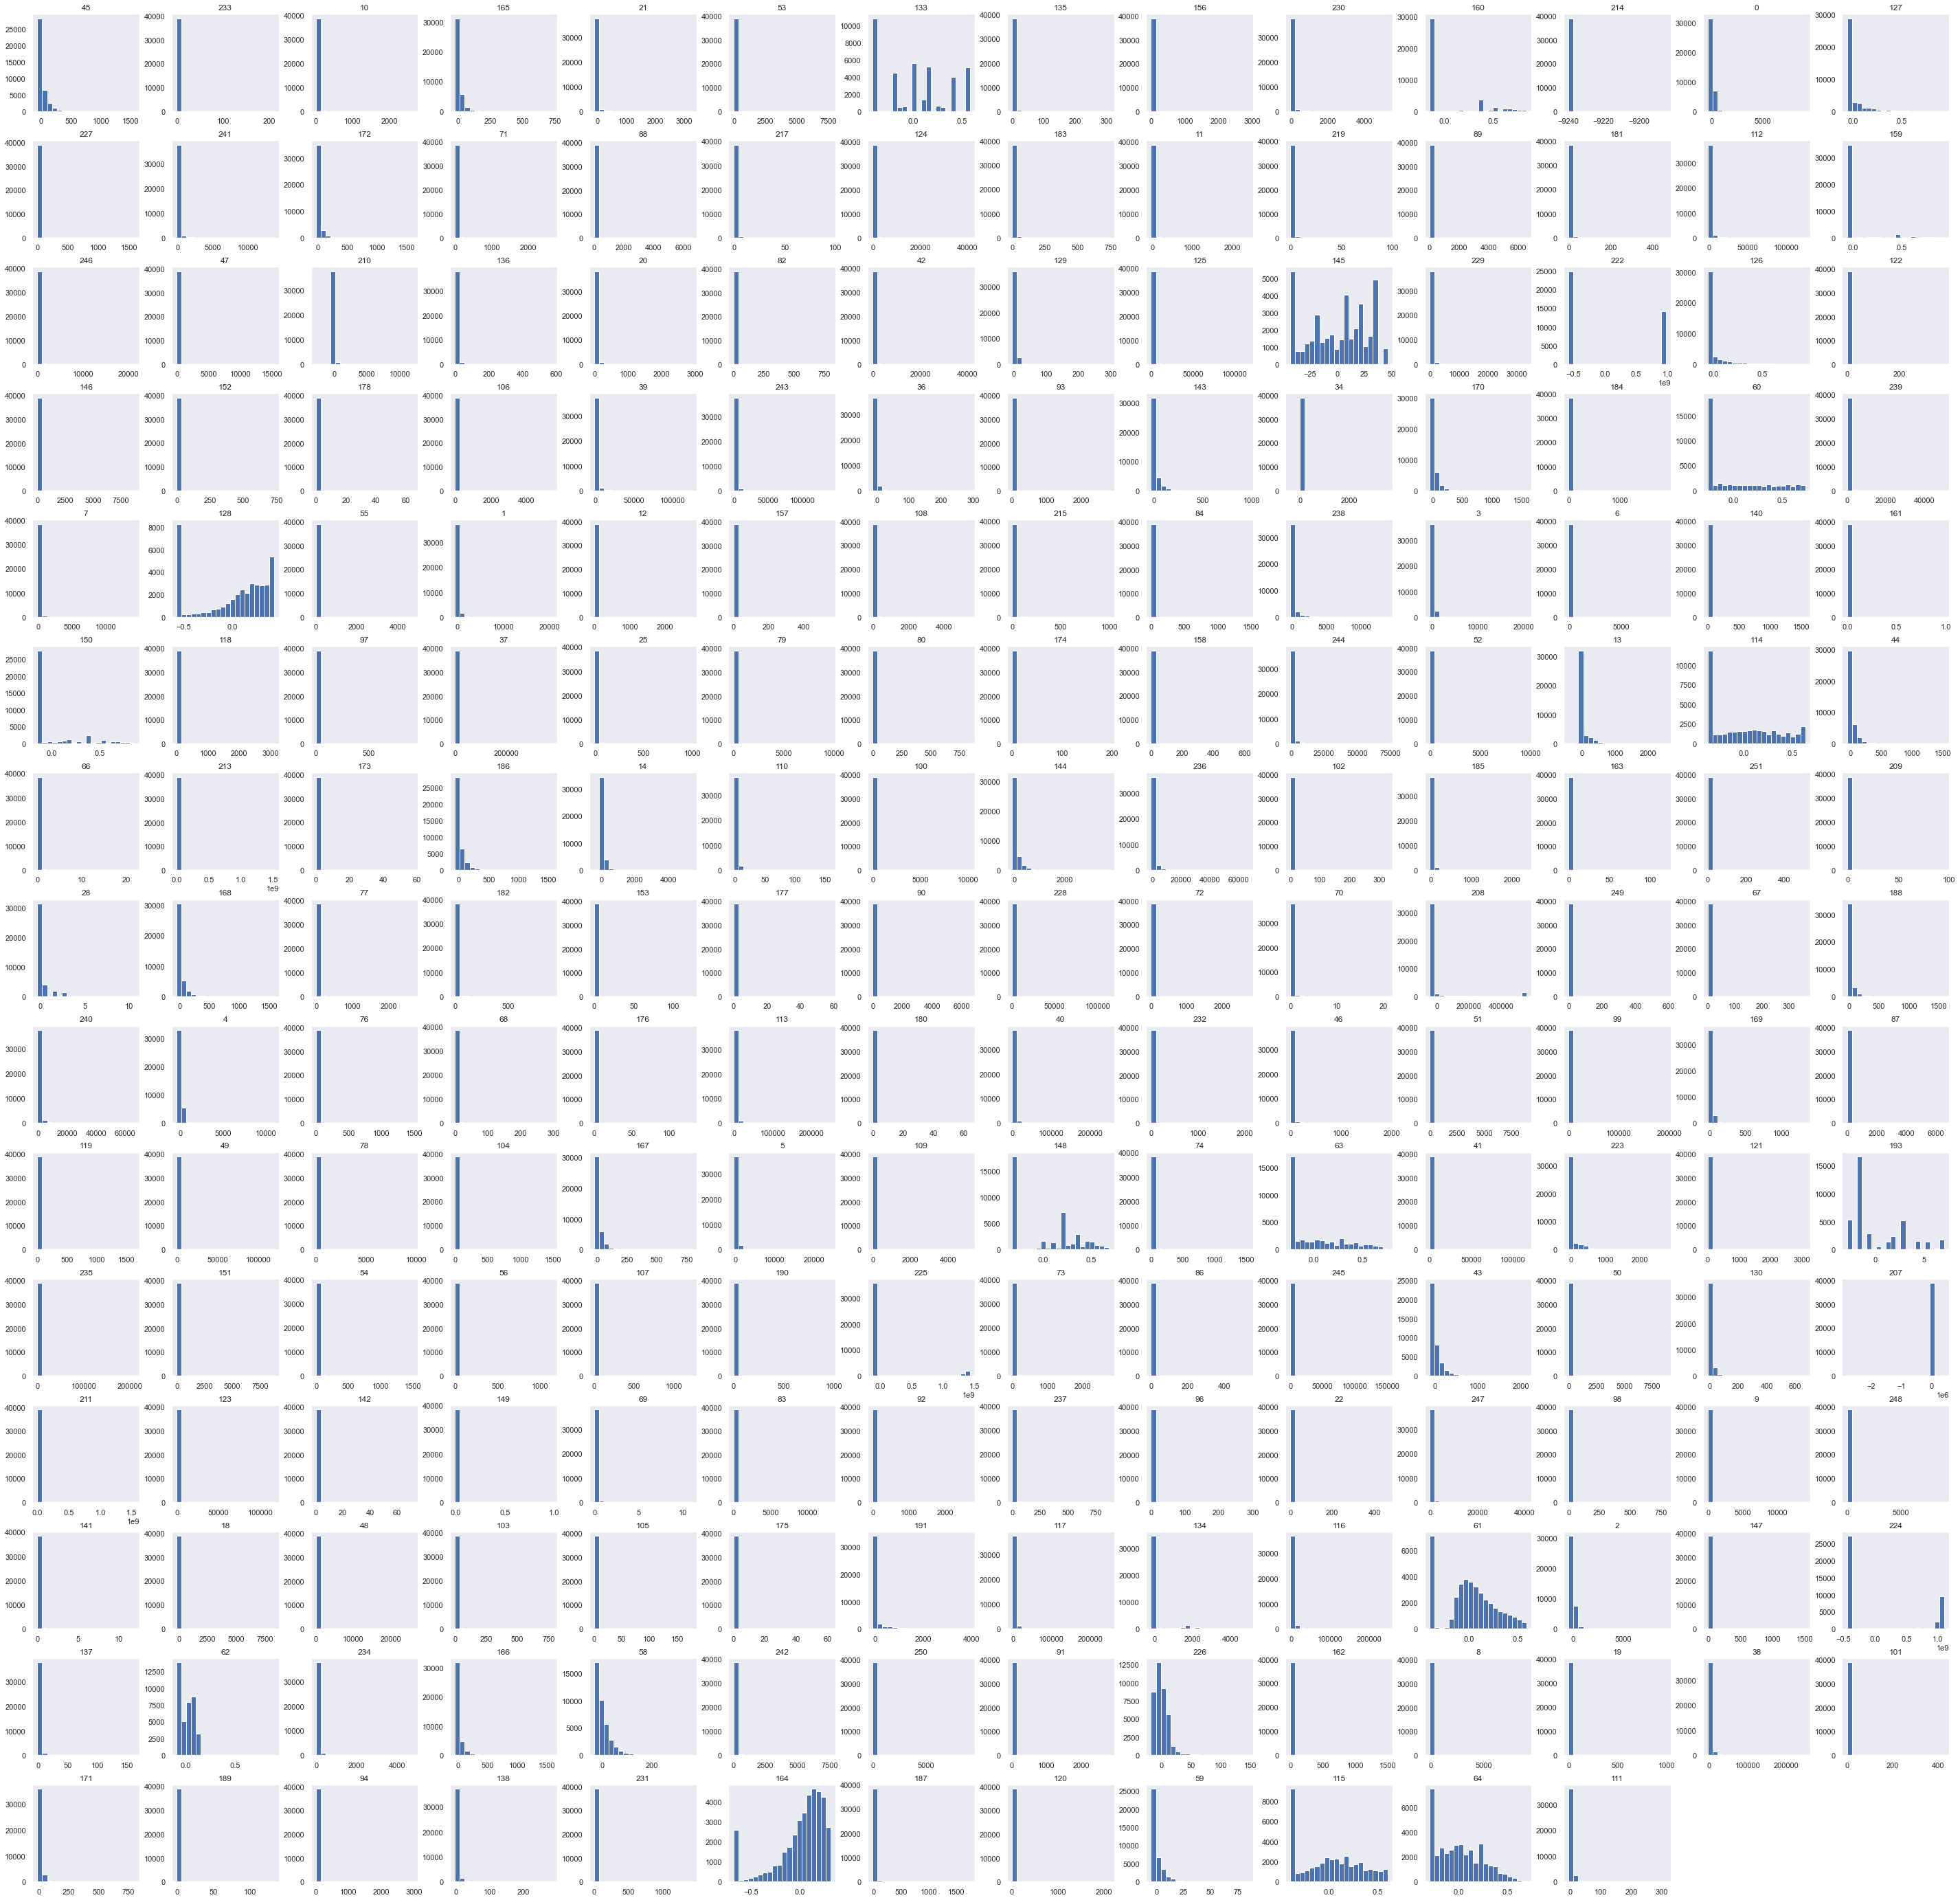

In [566]:
X[f_other].hist(figsize=(50, 50), bins=20, grid=False)
plt.show()

Большинство числовых признаков имеет выбросы.

In [535]:
continuos_cols = list(f_other) # числовые признаки
cat_cols = list(f_categorical) # условно категориальные признаки

### Разделение выборки на трейн и тест

In [151]:
from sklearn.model_selection import train_test_split

In [537]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['target', 'id', 'buy_time']), 
                                                    df_train['target'], random_state=0, test_size=0.25)

In [538]:
X_train.head()

,vas_id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
215915,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231731,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548488,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772481,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pipeline. XGBoost

In [138]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

In [242]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### Заполним существующие пропуски с помощью SimpleImputer. При этом пропуски в числовых признаках заменим на медиану, а в условно категориальных на константу, так как очень много пропусков.

In [243]:
step_num_imputer = ("num_imputer", SimpleImputer(strategy="median"))

In [510]:
step_cat_imputer = ("cat_imputer", SimpleImputer(strategy="constant"))

In [245]:
step_model = ('XGB', XGBClassifier(random_state=42, n_jobs=-1))

Подготовка данных для обучения модели:

In [539]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(continuos_cols),
            SimpleImputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(cat_cols),
            SimpleImputer(strategy="constant")
        ))
    ])
)

In [516]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns={'0', '1', '10', '100', '101', '102', '103', '104',
                          '105', '106', '107', '108', '109', '11', '110', '111',
                          '112', '113', '114', '115', '116', '117', '118', '119',
                          '12', '120', '121', '122', '123', '124', ...})),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['233',
                                                                           '21',
                                                                           '133',
                                                                           '135',
                                                                           '156',
                                                                           '230',
                                 

In [540]:
xgb_pipe = make_pipeline(
    f_prep_pipeline,
    XGBClassifier(random_state=42, n_jobs=-1)
)

In [541]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(207914, 254)

In [542]:
X_train.head()

,vas_id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
215915,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231731,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548488,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772481,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [543]:
%%time
xgb_pipe.fit(X_train, y_train)

[16:14:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 28min 29s, sys: 10.1 s, total: 28min 39s
Wall time: 4min 9s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [644]:
y_score_xgb_base = xgb_pipe.predict_proba(X_test)[:, 1]
y_score_xgb_base

array([0.13607232, 0.00242855, 0.01935056, ..., 0.01935056, 0.01853342,
       0.01853342], dtype=float32)

Функция для подсчета метрик и отсечки:

In [645]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

def get_metrics(probs, b=1):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    
    return thresholds[ix]

In [646]:
thr = get_metrics(y_score_xgb)
thr

Best Threshold=0.1848755180835724, F-Score=0.458, Precision=0.328, Recall=0.762


0.18487552

Вычисляем метрику F1(macro) для базовой модели XGBoost:

In [647]:
from sklearn.metrics import f1_score

f1_score(y_test, y_score_xgb_base > thr, average='macro')

0.6916435939245926

### Попробуем отбрать важные признаки с помощью RandomForestClassifier из SelectFromModel.

In [547]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

In [548]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(RandomForestClassifier(random_state=42), threshold=1e-5),
)

In [567]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(207914, 220)

Как видим, из 254 признаков осталось 220 наиболее важных. Обучимся на них и сравним метрики.

In [568]:
xgb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(RandomForestClassifier(random_state=42), threshold=1e-5),
    XGBClassifier(random_state=42, n_jobs=-1)
)

In [569]:
%%time
xgb_fs_pipe.fit(X_train, y_train)

[16:40:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 28min 13s, sys: 9.35 s, total: 28min 22s
Wall time: 6min 12s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [648]:
y_score_xgb = xgb_fs_pipe.predict_proba(X_test)[:, 1]
y_score_xgb

array([0.13607232, 0.00242855, 0.01935056, ..., 0.01935056, 0.01853342,
       0.01853342], dtype=float32)

In [653]:
thr = get_metrics(y_score_xgb)
thr

Best Threshold=0.1848755180835724, F-Score=0.458, Precision=0.328, Recall=0.762


0.18487552

In [654]:
f1_score(y_test, y_score_xgb > thr, average='macro')

0.6916435939245926

In [655]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_xgb)

In [656]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

XGBoost: AUC_ROC = 0.843


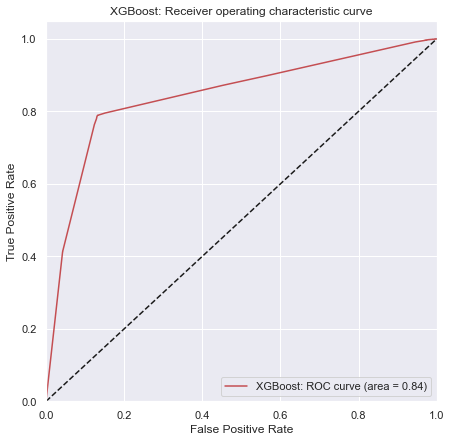

In [657]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "XGBoost", color='r')
print("XGBoost: AUC_ROC = %.3f" % auc(fpr, tpr))

### Матрица корреляций

In [658]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[168978  23758]
 [  3607  11571]]


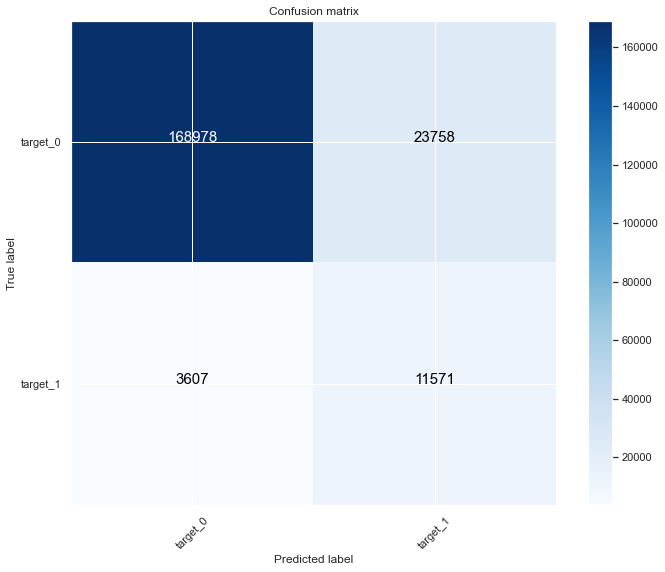

In [659]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_xgboost = confusion_matrix(y_test, y_score_xgb > thr)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_xgboost, classes=['target_0', 'target_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Попробуем улучшить модель с помощью подбора параметров для модели XGBoost

In [292]:
from sklearn.model_selection import GridSearchCV

In [302]:
[k for k in xgb_fs_pipe.get_params().keys() if 'xgbclassifier' in k]

['xgbclassifier',
 'xgbclassifier__objective',
 'xgbclassifier__use_label_encoder',
 'xgbclassifier__base_score',
 'xgbclassifier__booster',
 'xgbclassifier__colsample_bylevel',
 'xgbclassifier__colsample_bynode',
 'xgbclassifier__colsample_bytree',
 'xgbclassifier__gamma',
 'xgbclassifier__gpu_id',
 'xgbclassifier__importance_type',
 'xgbclassifier__interaction_constraints',
 'xgbclassifier__learning_rate',
 'xgbclassifier__max_delta_step',
 'xgbclassifier__max_depth',
 'xgbclassifier__min_child_weight',
 'xgbclassifier__missing',
 'xgbclassifier__monotone_constraints',
 'xgbclassifier__n_estimators',
 'xgbclassifier__n_jobs',
 'xgbclassifier__num_parallel_tree',
 'xgbclassifier__random_state',
 'xgbclassifier__reg_alpha',
 'xgbclassifier__reg_lambda',
 'xgbclassifier__scale_pos_weight',
 'xgbclassifier__subsample',
 'xgbclassifier__tree_method',
 'xgbclassifier__validate_parameters',
 'xgbclassifier__verbosity']

In [314]:
from sklearn.model_selection import GridSearchCV

params = {
    'xgbclassifier__learning_rate':[0.1, 0.5, 1.0],
    'xgbclassifier__n_estimators':[100, 300, 500],
    'xgbclassifier__max_depth':[3, 7, 10]
    
}

In [315]:
# %%time
# grid = GridSearchCV(xgb_fs_pipe,
#                     param_grid=params,
#                     cv=6,
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

[13:09:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 100}

Наилучшие подобранные параметры:

- 'xgbclassifier__learning_rate': 0.1,
- 'xgbclassifier__max_depth': 3,
- 'xgbclassifier__n_estimators': 100

In [585]:
xgb_final_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(RandomForestClassifier(random_state=42), threshold=1e-5),
    XGBClassifier(random_state=42, n_jobs=-1,learning_rate=0.1, max_depth=3, n_estimators=100)
)

In [586]:
%%time
xgb_final_pipe.fit(X_train, y_train)

[16:56:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 16min 22s, sys: 9.81 s, total: 16min 32s
Wall time: 4min 50s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [587]:
y_score_xgb_final = xgb_final_pipe.predict_proba(X_test)[:, 1]
y_score_xgb_final

array([0.23253565, 0.00292824, 0.02183869, ..., 0.02183869, 0.01886978,
       0.01886978], dtype=float32)

In [660]:
thr = get_metrics(y_score_xgb_final)
thr

Best Threshold=0.21984127163887024, F-Score=0.460, Precision=0.328, Recall=0.768


0.21984127

In [661]:
f1_score(y_test, y_score_xgb_final > thr, average='macro')

0.6925244720829736

Метрика f1 выросла по сравнению с базовой моделью XGBoost (было 0.6916435939245926)

XGBoost_opt: AUC_ROC = 0.842


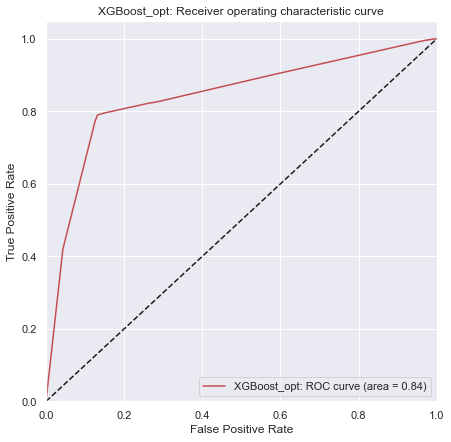

In [589]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_xgb_final)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "XGBoost_opt", color='r')
print("XGBoost_opt: AUC_ROC = %.3f" % auc(fpr, tpr))

Confusion matrix, without normalization
[[168894  23842]
 [  3523  11655]]


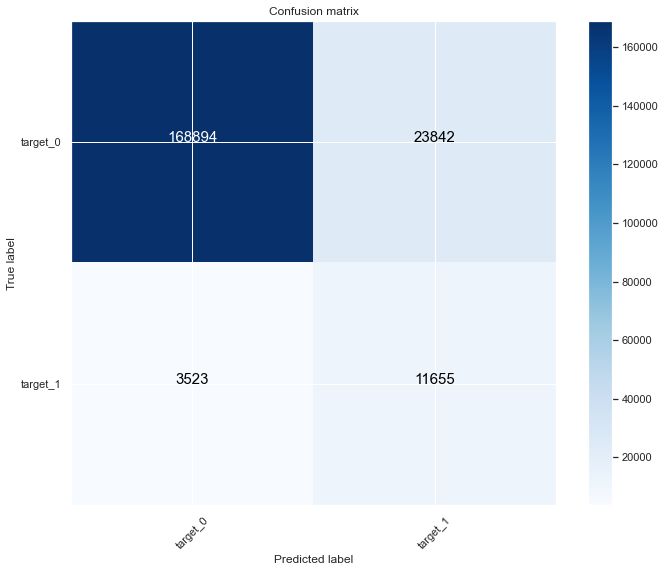

In [590]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_xgboost = confusion_matrix(y_test, y_score_xgb_final > thr)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_xgboost, classes=['target_0', 'target_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [662]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_score_xgb_final > thr))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93    192736
           1       0.33      0.77      0.46     15178

    accuracy                           0.87    207914
   macro avg       0.65      0.82      0.69    207914
weighted avg       0.93      0.87      0.89    207914



## Обучение модели GradientBoostingClassifier с отбором признков с помощью  Logistic Regression

In [605]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [596]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=42), threshold=1e-5),
)

In [597]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(207914, 247)

Из 254 признаков осталось 247. Обучим модель градиентного бустинга на отобранных признаках:

In [630]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=42), threshold=1e-5),
    GradientBoostingClassifier(learning_rate=0.5, n_estimators=300)
)

In [631]:
%%time
gb_fs_pipe.fit(X_train, y_train)

CPU times: user 16min 54s, sys: 11.4 s, total: 17min 6s
Wall time: 16min 17s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [632]:
y_score_gb = gb_fs_pipe.predict_proba(X_test)[:, 1]
y_score_gb

array([0.16670432, 0.00118542, 0.01910149, ..., 0.01910149, 0.01858855,
       0.01858855])

In [663]:
thr = get_metrics(y_score_gb)
thr

Best Threshold=0.18841826969009629, F-Score=0.458, Precision=0.327, Recall=0.762


0.18841826969009629

In [664]:
f1_score(y_test, y_score_gb > thr, average='macro')

0.691311781505032

GradientBoosting: AUC_ROC = 0.843


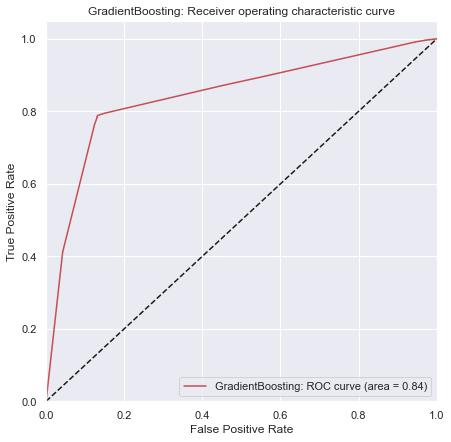

In [636]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_gb)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "GradientBoosting", color='r')
print("GradientBoosting: AUC_ROC = %.3f" % auc(fpr, tpr))

In [665]:
print(classification_report(y_test, y_score_gb > thr))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92    192736
           1       0.33      0.76      0.46     15178

    accuracy                           0.87    207914
   macro avg       0.65      0.82      0.69    207914
weighted avg       0.93      0.87      0.89    207914



## Обучение с помощью модели CatBoostClassifier

In [306]:
from catboost import CatBoostClassifier

In [615]:
catboost_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(CatBoostClassifier(random_state=42), threshold=1e-5),
    CatBoostClassifier(random_state=42,eval_metric='F1',silent=True, learning_rate=0.1, early_stopping_rounds=20)
)

In [616]:
%%time
catboost_fs_pipe.fit(X_train, y_train)

Learning rate set to 0.160842
0:	learn: 0.4786648	total: 176ms	remaining: 2m 56s
1:	learn: 0.3570229	total: 351ms	remaining: 2m 55s
2:	learn: 0.3015208	total: 495ms	remaining: 2m 44s
3:	learn: 0.2607875	total: 628ms	remaining: 2m 36s
4:	learn: 0.2399012	total: 762ms	remaining: 2m 31s
5:	learn: 0.2198040	total: 892ms	remaining: 2m 27s
6:	learn: 0.2137558	total: 1.02s	remaining: 2m 25s
7:	learn: 0.2034065	total: 1.17s	remaining: 2m 24s
8:	learn: 0.1969661	total: 1.34s	remaining: 2m 27s
9:	learn: 0.1928526	total: 1.48s	remaining: 2m 26s
10:	learn: 0.1913987	total: 1.61s	remaining: 2m 24s
11:	learn: 0.1893679	total: 1.76s	remaining: 2m 24s
12:	learn: 0.1882325	total: 1.92s	remaining: 2m 25s
13:	learn: 0.1872136	total: 2.07s	remaining: 2m 25s
14:	learn: 0.1870262	total: 2.2s	remaining: 2m 24s
15:	learn: 0.1864169	total: 2.35s	remaining: 2m 24s
16:	learn: 0.1859710	total: 2.49s	remaining: 2m 24s
17:	learn: 0.1857319	total: 2.62s	remaining: 2m 23s
18:	learn: 0.1855605	total: 2.76s	remaining: 

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns={'0', '1', '10', '100',
                                                          '101', '102', '103',
                                                          '104', '105', '106',
                                                          '107', '108', '109',
                                                          '11', '110', '111',
                                                          '112', '113', '114',
                                                          '115', '116', '117',
                                                          '118', '119', '12',
                                                          '120', '121', '122',
                                                          '123', '124', ...})),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_fea

In [617]:
y_score_catboost= catboost_fs_pipe.predict_proba(X_test)[:, 1]
y_score_catboost

array([0.20355582, 0.00245291, 0.0191005 , ..., 0.0191005 , 0.01863586,
       0.01863586])

In [666]:
thr = get_metrics(y_score_catboost)
thr

Best Threshold=0.18676926850382586, F-Score=0.459, Precision=0.328, Recall=0.766


0.18676926850382586

In [667]:
f1_score(y_test, y_score_catboost > thr, average='macro')

0.6918564007841937

Метрика у настроенной модели XGBClassifier немного лучше, чем у CatBoost ( у xgboost f1_score=0.6925244720829736)

Confusion matrix, without normalization
[[168876  23860]
 [  3557  11621]]


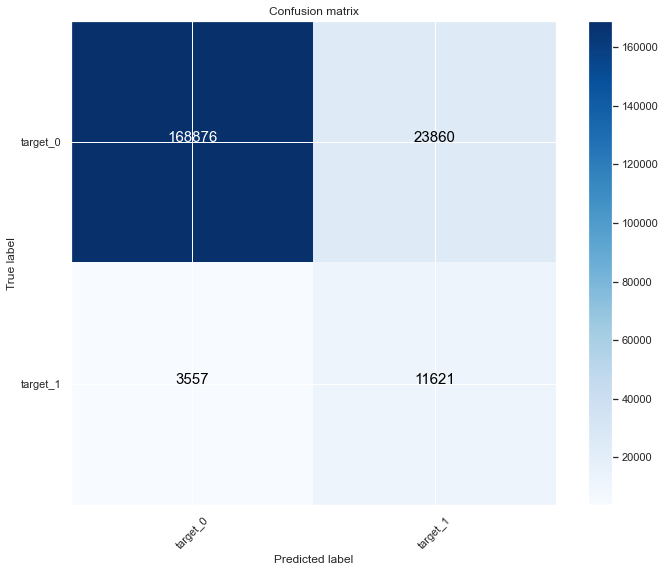

In [619]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_catboost = confusion_matrix(y_test, y_score_catboost > thr)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_catboost, classes=['target_0', 'target_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [620]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_catboost)

CatBoost: AUC_ROC = 0.843


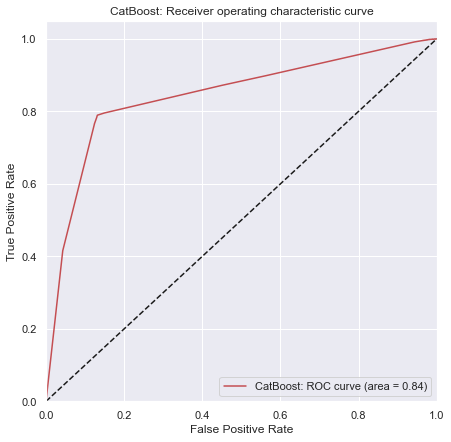

In [621]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoost", color='r')
print("CatBoost: AUC_ROC = %.3f" % auc(fpr, tpr))

In [622]:
print(classification_report(y_test, y_score_catboost > thr))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92    192736
           1       0.33      0.77      0.46     15178

    accuracy                           0.87    207914
   macro avg       0.65      0.82      0.69    207914
weighted avg       0.93      0.87      0.89    207914



GradientBoosting: AUC_PR = 0.350
GradientBoosting: AUC_ROC = 0.843
XGBoost_final: AUC_PR = 0.367
XGBoost_final: AUC_ROC = 0.842
CatBoost: AUC_PR = 0.360
CatBoost: AUC_ROC = 0.843


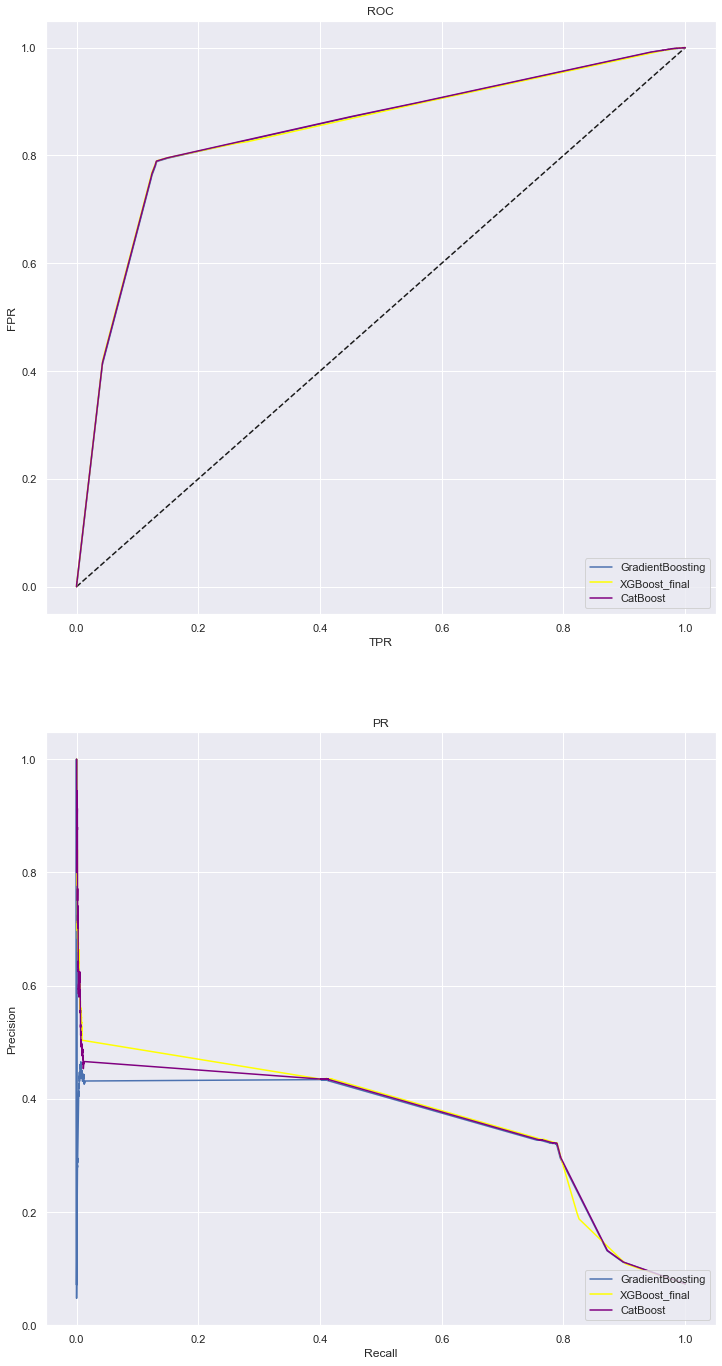

In [668]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_gb)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score_gb)
ax1.plot(fpr, tpr, label='GradientBoosting', color='b')
ax2.plot(recall, precision, label='GradientBoosting', color='b')
print("GradientBoosting: AUC_PR = %.3f" % auc(recall, precision))
print("GradientBoosting: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_xgb_final)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score_xgb_final)
ax1.plot(fpr, tpr, label="XGBoost_final", color='yellow')
ax2.plot(recall, precision, label="XGBoost_final", color='yellow')
print("XGBoost_final: AUC_PR = %.3f" % auc(recall, precision))
print("XGBoost_final: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_catboost)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score_catboost)
ax1.plot(fpr, tpr, label="CatBoost", color='purple')
ax2.plot(recall, precision, label="CatBoost", color='purple')
print("CatBoost: AUC_PR = %.3f" % auc(recall, precision))
print("CatBoost: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

У всех моделей получается примерно одинаковая ROC-AUC кривая, PR-кривая лучше всего у модели XGBoost с настроенными гиперпараметрами.

## Сохранение наилучшей модели

In [669]:
with open('xgboost.pickle', 'wb') as f:
    pickle.dump(xgb_final_pipe, f)

## Предсказания на тестовом датасете

In [376]:
df_test.head(2)

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2,2019-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000860,4,2019-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [671]:
with open('xgboost.pickle', 'rb') as f:
    xgb_pipeline = pickle.load(f)

In [672]:
y_score_final = xgb_pipeline.predict_proba(df_test)[:, 1]
y_score_final

array([0.0197268, 0.2509479, 0.0197268, ..., 0.0197268, 0.0197268,
       0.0197268], dtype=float32)

In [682]:
answers_test = df_test[['id', 'vas_id', 'buy_time']]
answers_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20
1,2000860,4,2019-01-20
2,1099444,2,2019-01-06
3,1343255,5,2019-01-13
4,1277040,2,2019-01-06
...,...,...,...
71226,2502453,5,2019-01-20
71227,1693213,2,2019-01-20
71228,1891350,2,2019-01-20
71229,2437172,2,2019-01-20


In [683]:
answers_test['target'] = y_score_final

Best Threshold=0.21984127163887024 для лучшей модели XGBoost. Поэтому заменим те значения вероятностей подключения услуги, которые больше отсечки, на 1, а остальные на 0.

In [676]:
thr = 0.21984127163887024

In [685]:
answers_test[answers_test['target'] > thr]

,id,vas_id,buy_time,target
1,2000860,4,2019-01-20,0.250948
6,3195325,6,2019-01-20,0.421159
11,854258,6,2019-01-13,0.421159
26,2219493,6,2019-01-06,0.421159
31,1847529,4,2019-01-06,0.250948
...,...,...,...,...
71126,3598995,6,2019-01-20,0.421159
71130,653076,6,2019-01-13,0.421159
71134,3087071,6,2019-01-20,0.421159
71144,4299024,6,2019-01-20,0.421159


In [686]:
answers_test['target'] = np.where((answers_test.target < thr), 0, answers_test.target)
answers_test['target'] = np.where(~(answers_test.target < thr), 1, answers_test.target)

In [687]:
answers_test['target'] = answers_test['target'].astype('int')

In [688]:
answers_test.head()

,id,vas_id,buy_time,target
0,3130519,2,2019-01-20,0
1,2000860,4,2019-01-20,1
2,1099444,2,2019-01-06,0
3,1343255,5,2019-01-13,0
4,1277040,2,2019-01-06,0


In [689]:
answers_test.to_csv('answers_test.csv', index=False)

Проверка, что все записалось как нужно:

In [691]:
test = pd.read_csv('answers_test.csv')
test.head()

,id,vas_id,buy_time,target
0,3130519,2,2019-01-20,0
1,2000860,4,2019-01-20,1
2,1099444,2,2019-01-06,0
3,1343255,5,2019-01-13,0
4,1277040,2,2019-01-06,0
